In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_helpers import *
import seaborn as sns
import pandas as pd
from plot_helpers import *
from operator import itemgetter
from scipy.stats import invwishart
import time
import random

In [17]:
## posterior function:
   
    
def params_init(mu_0, psi_0, kappa_0):
    frame_list_5 = [data_Jorge1, data_Jorge2, data_Jorge3, data_Jorge4, data_Jorge5]
    chosen_Jorge = random.choice(frame_list_5)
    data = chosen_Jorge.sample(1, replace=True)
    mu_0 = np.array(mu_0) ## random initialization of mu_s for two distribution
    mean_data = (np.mean(data, axis = 0))
    #psi_0 = (np.eye(mu_0.shape[0])*10).T
    inv_psi_0 = np.linalg.inv(psi_0)
    dim = mu_0.shape[0]
    nu_0 = dim + 2
    n = data.shape[0]
    
    sum_square_0 = np.sum(np.square(data['X_0']-mean_data[0]))
    sum_square_1 = np.sum(np.square(data['X_1']-mean_data[1]))
    
    sum_squares = np.array([sum_square_0,sum_square_1])
    mu_n = np.array(((kappa_0 * mu_0) + (n * mean_data)) / (kappa_0 + n))
    kappa_n = kappa_0 + n
    nu_n = nu_0 + n
    psi_n = psi_0 + sum_squares + kappa_0 * n / float(kappa_0 + n) * np.array(np.matrix(mean_data - mu_0).T * np.matrix(mean_data - mu_0))
    
    params_dict = {"sum_squares":sum_squares, "mu_n":mu_n, "kappa_n": kappa_n, "nu_n": nu_n, "psi_n": psi_n}
    return(params_dict)
    
    ##sum_squares = np.sum([np.array(np.matrix(x - mu_0).T * np.matrix(x - mu_0)) for x in data], axis=0)
 
    
def model(data,mu_n,kappa_n,nu_n,psi_n):
    #psi_n =  np.array([[2000,0],[0,2000]])
    #nu_n = 6
    sigma =  invwishart.rvs(nu_n, psi_n, size=1, random_state=None)
    mu = np.random.multivariate_normal(np.array(mu_n),np.matrix(sigma/kappa_n))
    X_p = np.random.multivariate_normal(mu,sigma)
    return({'sigma':sigma, 'mu':mu, 'X_p':X_p})

def model_iter(data, mu_0, kappa_0, psi_0, iter):
    
    params_dict = params_init(data,mu_0,psi_0,kappa_0)
    sum_squares, mu_n, kappa_n, nu_n, psi_n = itemgetter('sum_squares','mu_n','kappa_n','nu_n','psi_n' )(params_dict)
    
    mu_list = []
    X_list = []
    sigma_list = []

    for i in range(iter):
        model_i = model(data,mu_n,kappa_n,nu_n,psi_n)
        sigma_i, mu_i, X_pi = itemgetter('sigma','mu','X_p')(model_i)
        
        mu_list.append(mu_i)
        X_list.append(X_pi)
        sigma_list.append(sigma_i)
        
    return({'mu_list':mu_list, 'X_list':X_list, 'sigma_list':sigma_list})


def hartree_code(filepath):
    data = pd.read_fwf(filepath, comment='#', header=None)
    data_str = (data.loc[2,0])
    data_val = data_str.strip('][').split(', ')
    A_mean = float(data_val[0])
    B_mean = float(data_val[1])
    Cov = float(data_val[2])*float(data_val[3])*float(data_val[4])
    A_std = float(data_val[2])
    B_std = float(data_val[3])
    return (A_mean, B_mean, Cov, A_std, B_std)


def plotkde1(filename):
    data1 = np.loadtxt(filename, delimiter=',', skiprows=1)
    sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=False, levels=[.05,1], color="orange")
    legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', 
                                   edgecolor="orange", label=f"Schunck+ (2020) (95\%)")) 


def plotkde2(filename):
    data1 = np.loadtxt(filename, delimiter=',', skiprows=1)
    sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=False, levels=[.05,1], color="darkcyan")
    legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', 
                                   edgecolor="darkcyan", label=f"Schunck+ (2020) (95\%)")) 

    
def plotkde3(filename):
    data1 = np.loadtxt(filename, delimiter=',', skiprows=1)
    sns.kdeplot(x=data1[:,0], y=data1[:,1], fill=False, levels=[.05,1], color="darkslateblue")
    legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', 
                                   edgecolor="darkslateblue", label=f"Schunck+ (2020) (95\%)")) 

    
def model_iter_Jorge(mu_0, kappa_0, psi_0, iter):    
    params_dict = params_init(data,mu_0,psi_0,kappa_0)
    sum_squares, mu_n, kappa_n, nu_n, psi_n = itemgetter('sum_squares','mu_n','kappa_n','nu_n','psi_n' )(params_dict)
    
    mu_list = []
    X_list = []
    sigma_list = []

    for i in range(iter):       
        model_i = model(data,mu_n,kappa_n,nu_n,psi_n)
        sigma_i, mu_i, X_pi = itemgetter('sigma','mu','X_p')(model_i)
        
        mu_list.append(mu_i)
        X_list.append(X_pi)
        sigma_list.append(sigma_i)
        
    return({'mu_list':mu_list, 'X_list':X_list, 'sigma_list':sigma_list})




In [12]:
dtypes={"Label":str, "rho0":np.float64, "E/aA": np.float64}
data_skyrme=pd.read_csv("data/satpoints_skyrme.csv", comment="#", dtype=dtypes)
data_rmf=pd.read_csv("data/satpoints_rmf.csv", comment="#", dtype=dtypes)
data_FC1=pd.read_csv("data/forChristan_samples1.csv",comment="#", names=["rho0","E/A"])
data_FC2=pd.read_csv("data/forChristan_samples2.csv",comment="#", names=["rho0","E/A"])
data_FC3=pd.read_csv("data/forChristan_samples3.csv",comment="#", names=["rho0","E/A"])

def import_fwf_data(filepath, column_name):
    data = pd.read_fwf(filepath, skiprows=7, comment='#', usecols=column_name)
    return data.rename(columns={column_name[0]:"rho0", column_name[1]:"E/A"})
                       
data_RMF012_1 = import_fwf_data("saturation/RMF012/CovEllipse.out", ["A39","B39"])
data_RMF012_2 = import_fwf_data("saturation/RMF012/CovEllipse.out", ["A95","B95"])
data_RMF016_1 = import_fwf_data("saturation/RMF016/CovEllipse.out", ["A39","B39"])
data_RMF016_2 = import_fwf_data("saturation/RMF016/CovEllipse.out", ["A95","B95"])
data_RMF022_1 = import_fwf_data("saturation/RMF022/CovEllipse.out", ["A39","B39"])
data_RMF022_2 = import_fwf_data("saturation/RMF022/CovEllipse.out", ["A95","B95"])
data_RMF028_1 = import_fwf_data("saturation/RMF028/CovEllipse.out", ["A39","B39"])
data_RMF028_2 = import_fwf_data("saturation/RMF028/CovEllipse.out", ["A95","B95"])
data_RMF032_1 = import_fwf_data("saturation/RMF032/CovEllipse.out", ["A39","B39"])
data_RMF032_2 = import_fwf_data("saturation/RMF032/CovEllipse.out", ["A95","B95"])

def insert_type(typename, data):
    data["type"]=typename
    return data


insert_type("Skyrme", data_skyrme)
insert_type("RMF", data_rmf)


def insert_type_and_label(typename, labelname, data):
    data["type"]=typename
    data["Label"]=labelname
    return data

insert_type_and_label("Schunck", "UNDEF", data_FC1)
insert_type_and_label("Schunck", "UNDEF", data_FC2)
insert_type_and_label("Schunck", "UNDEF", data_FC3)
insert_type_and_label("RMF012", "temp", data_RMF012_1)
insert_type_and_label("RMF012", "temp", data_RMF012_2)
insert_type_and_label("RMF016", "temp", data_RMF016_1)
insert_type_and_label("RMF016", "temp", data_RMF016_2)
insert_type_and_label("RMF022", "temp", data_RMF022_1)
insert_type_and_label("RMF022", "temp", data_RMF022_2)
insert_type_and_label("RMF028", "temp", data_RMF028_1)
insert_type_and_label("RMF028", "temp", data_RMF028_2)
insert_type_and_label("RMF032", "temp", data_RMF032_1)
insert_type_and_label("RMF032", "temp", data_RMF032_2)



data=pd.concat([data_skyrme, data_rmf, data_FC1, data_FC2, data_FC3, data_RMF012_1, data_RMF012_2, data_RMF016_1, data_RMF016_2, data_RMF022_1, data_RMF022_2, data_RMF028_1, data_RMF028_2, data_RMF032_1, data_RMF032_2])

data.head(n=10000)

#Data Jorge
jorge_cov_1 = np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]])
jorge_mean_1 = np.array([A_12, B_12])
jorge_cov_2 = np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]])
jorge_mean_2 = np.array([A_16, B_16])
jorge_cov_3 = np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]])
                       
jorge_mean_3 =  np.array([A_22, B_22])
                       
jorge_cov_4 = np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]])
                       
jorge_mean_4 = np.array([A_28, B_28])
                       
jorge_cov_5 = np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]])
                       
jorge_mean_5 = np.array([A_32, B_32])
                       
data_Jorge1 = pd.DataFrame(np.random.multivariate_normal([A_12,B_12],jorge_cov_1,1000))
data_Jorge2 = pd.DataFrame(np.random.multivariate_normal([A_16,B_16],jorge_cov_2,1000)) 
data_Jorge3 = pd.DataFrame(np.random.multivariate_normal([A_22,B_22],jorge_cov_3,1000))  
data_Jorge4 = pd.DataFrame(np.random.multivariate_normal([A_28,B_28],jorge_cov_4,1000))
data_Jorge5 = pd.DataFrame(np.random.multivariate_normal([A_32,B_32],jorge_cov_5,1000))
#frame_list_5 = [data_Jorge1, data_Jorge2, data_Jorge3, data_Jorge4, data_Jorge5]
#chosen_Jorge = random.choice(frame_list_5)


#Schunck 
data_Schunck1 = pd.DataFrame(np.loadtxt("data/forChristan_samples1.csv", delimiter=','))
data_Schunck2 = pd.DataFrame(np.loadtxt("data/forChristan_samples2.csv", delimiter=','))
data_Schunck3 = pd.DataFrame(np.loadtxt("data/forChristan_samples3.csv", delimiter=','))
#frame_list_3 = [data_Schunck1,data_Schunck2,data_Schunck3]
#chosen_Schunck = random.choice(frame_list_3)

#RMF
data_RMF =pd.DataFrame(df)

#Skyrme
data_Skyrme =pd.DataFrame(df1)

#McDonnell
McDonnell_mean = np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])])
McDonnell_cov = np.diag([0.005,0.25])**2
data_McDonnell = pd.DataFrame(np.random.multivariate_normal(McDonnell_mean,McDonnell_cov,1000))

Text(0, 0.5, 'Saturation Energy $E_0/A$ [MeV]')

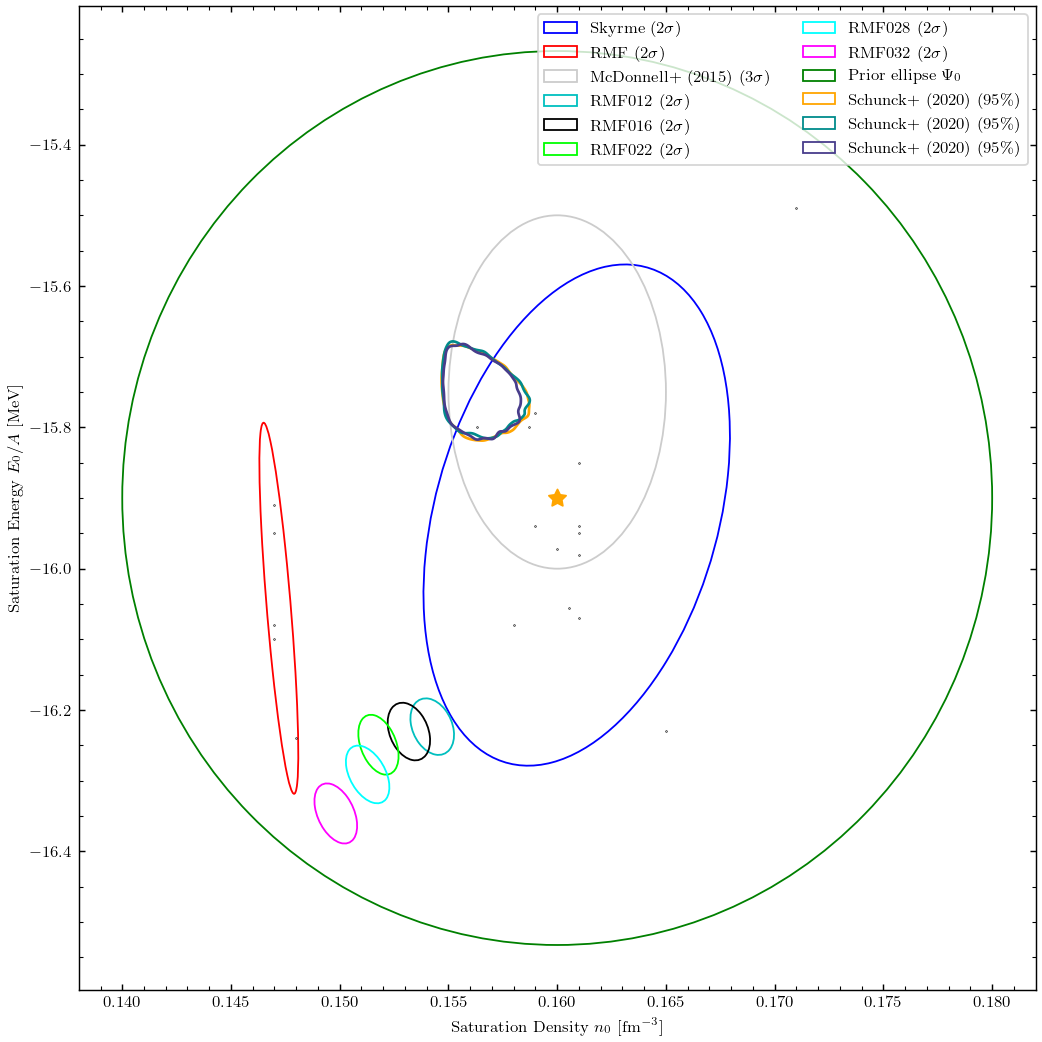

In [10]:
#prior mean
fig, ax = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
legend_elements=[]
prior_mean_0 = np.array([0.16, -15.9])
prior_psi_0 = np.array([[.0001,0],[0,.1]])
prior_mean_x = 0.16
prior_mean_y = -15.9
df = pd.read_csv("data/satpoints_rmf.csv", comment="#", usecols = ['rho0','E/A'])
df1 = pd.read_csv("data/satpoints_skyrme.csv", comment="#", usecols = ['rho0','E/A'])

A_12, B_12, Cov_12, A_std_12, B_std_12 = hartree_code("saturation/RMF012/CovEllipse.com")
A_16, B_16, Cov_16, A_std_16, B_std_16 = hartree_code("saturation/RMF016/CovEllipse.com")
A_22, B_22, Cov_22, A_std_22, B_std_22 = hartree_code("saturation/RMF022/CovEllipse.com")
A_28, B_28, Cov_28, A_std_28, B_std_28 = hartree_code("saturation/RMF028/CovEllipse.com") 
A_32, B_32, Cov_32, A_std_32, B_std_32 = hartree_code("saturation/RMF032/CovEllipse.com") 



#X_1 = np.random.choice(chosen_Jorge)
#print(X_1)

color=edgecolor="0.8"

for imodel,model in enumerate(("Skyrme", "RMF")):
    masked_data=data[data["type"]==model]
    color=colorset[imodel]
    confidence_ellipse(masked_data["rho0"], masked_data["E/A"], 
                       ax, n_std=2.0, facecolor='none',edgecolor=color, show_scatter=True)
    legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor=color, label=f"{model} (2$\\sigma$)"))  
    
ax.scatter(prior_mean_x,prior_mean_y, alpha = 1, s=100, marker=(5,1), label = 'Prior mean', c='orange')   
#legend_elements.append(Ellipse((0, 0), width=1, height=1, markers="*", label=f"Prior mean"))
    
confidence_ellipse_mean_cov(np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])]), np.diag([0.005,0.25])**2, 
                            ax=ax, n_std=1, facecolor='none', edgecolor="0.8")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="0.8", 
                               label=f"McDonnell+ (2015) (3$\\sigma$)"))


confidence_ellipse_mean_cov(np.array([A_12, B_12]), np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="c")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="c", label=f"RMF012 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_16, B_16]), np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="k")
legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', edgecolor="k", label=f"RMF016 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_22, B_22]), np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]]),
                           ax=ax, n_std=2,facecolor='none', edgecolor="lime")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="lime", label=f"RMF022 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_28, B_28]), np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="aqua")
legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', edgecolor="aqua", label=f"RMF028 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_32, B_32]), np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]]),
                           ax=ax, n_std=2, facecolor="none", edgecolor="magenta")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="magenta", label=f"RMF032 (2$\\sigma$)"))

confidence_ellipse_mean_cov(prior_mean_0,prior_psi_0, ax=ax, n_std=2, facecolor='none', edgecolor ='green' )
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="green", 
                               label=f"Prior ellipse $\\Psi_0$"))

plotkde1("data/forChristan_samples1.csv")
plotkde2("data/forChristan_samples2.csv")
plotkde3("data/forChristan_samples3.csv")


ax.legend(handles=legend_elements, loc='best', fontsize='medium', ncol=2)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')

In [18]:
model_iter_Jorge(prior_mean_0, 1, prior_psi_0, 1000)

KeyError: 'X_0'

In [5]:
def model_2_iter_Jorge(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        frame_list_5 = [data_Jorge1, data_Jorge2, data_Jorge3, data_Jorge4, data_Jorge5]
        chosen_Jorge = random.choice(frame_list_5)
        data = chosen_Jorge.sample(1, replace=True)
        data.columns = ['X_0','X_1']
        model_iter_model_1 = model_iter(data, prior_mean_0, 1, prior_psi_0, 1)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_model_1)
        mu_s = pd.DataFrame(mu_list)             
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})


def model_2_iter_Schunck(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        frame_list_3 = [data_Schunck1,data_Schunck2,data_Schunck3]
        chosen_Schunck = random.choice(frame_list_3)
        data = chosen_Schunck.sample(1, replace=True)
        data.columns = ['X_0','X_1']
        model_iter_model_1 = model_iter(data, prior_mean_0,1, prior_psi_0, 1)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_model_1)
        mu_s = pd.DataFrame(mu_list)             
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})



def model_2_iter_RMF(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        data = data_RMF.sample(1, replace=True)
        data.columns = ['X_0','X_1']
        model_iter_model_1 = model_iter(data, prior_mean_0, 1, prior_psi_0, 1)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_model_1) 
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})


# 2 loops, 100-1000 blue points, 1-10 mu, sigma, y

def model_2_iter_Skyrme(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        data = data_Skyrme.sample(1, replace=True)
        data.columns = ['X_0','X_1']
        model_iter_model_1 = model_iter(data, prior_mean_0, 1, prior_psi_0, 1)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_model_1) 
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})



def model_2_iter_McDonnell(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []
    
    for i in range(iterations):
        data = data_McDonnell.sample(1, replace=True)
        data.columns = ['X_0','X_1']
        model_iter_model_1 = model_iter(data, prior_mean_0, 1, prior_psi_0, 1)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_iter_model_1) 
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)
        
    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})



TypeError: 'str' object is not callable

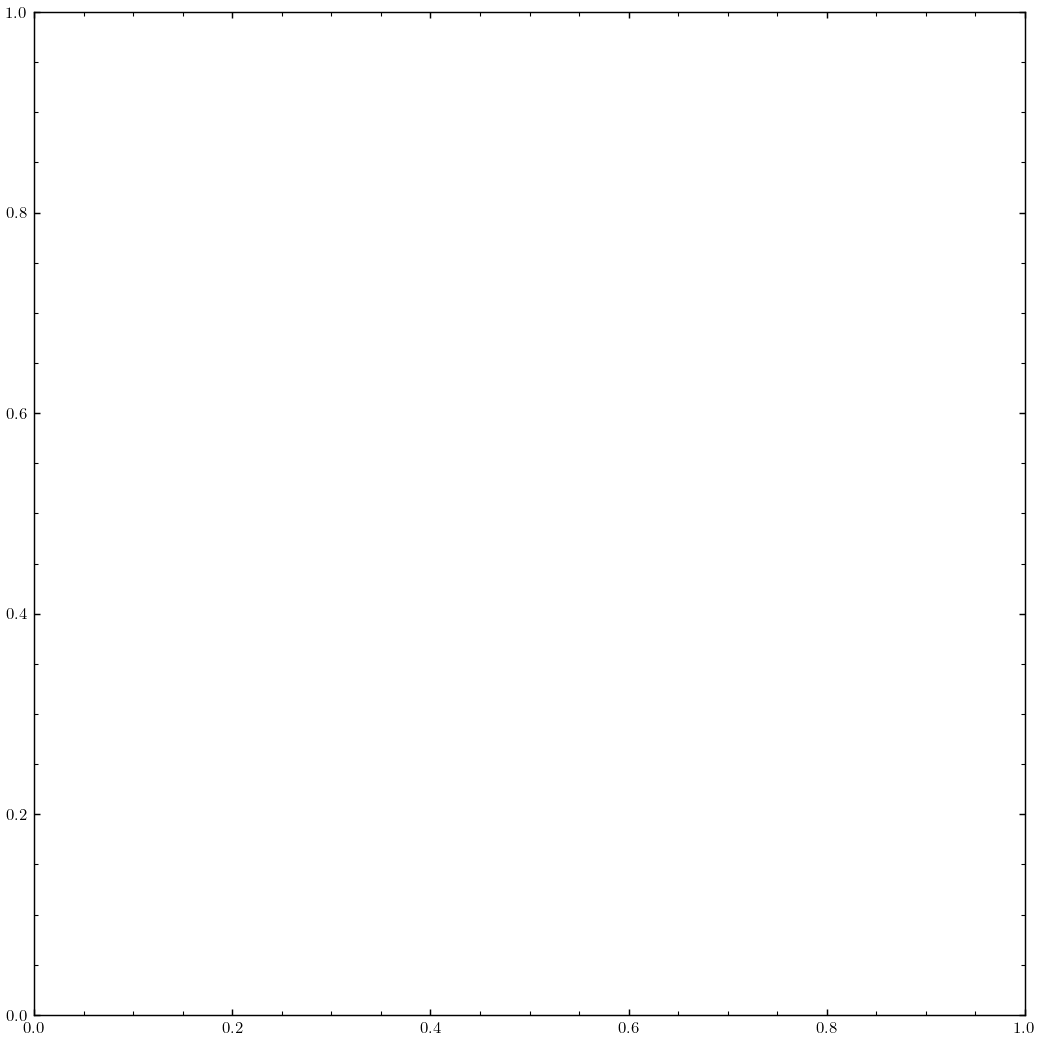

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
legend_elements=[]

#Model Jorge
model_1 = model_2_iter_Jorge(1000)

#Model Schunck
model_2 = model_2_iter_Schunck(1000)

#Model RMF
model_3 = model_2_iter_RMF(1000)

#Model Skyrme
model_4 = model_2_iter_Skyrme(1000)

#Model McDonnell
model_5 = model_2_iter_McDonnell(1000)

#Model Jorge Summary
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_1)

mu_s_model_1 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_1.columns = ['mu_0','mu_1']
X_pred_model_1 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_1.columns = ['X_0','X_1']

sigma_array_model_1 = np.array(sigma_list)
sigma_array_reshape_model_1 = sigma_array_model_1.reshape(1000,2*2)
sigma_mean_posterior_model_1 = np.reshape(np.mean(sigma_array_reshape_model_1,axis = 0), (2,2))

#Model Schunck Summary
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_2)

mu_s_model_2 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_2.columns = ['mu_0','mu_1']
X_pred_model_2 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_2.columns = ['X_0','X_1']

sigma_array_model_2 = np.array(sigma_list)
sigma_array_reshape_model_2 = sigma_array_model_2.reshape(1000,2*2)
sigma_mean_posterior_model_2 = np.reshape(np.mean(sigma_array_reshape_model_2,axis = 0), (2,2))

#Model RMF Summary
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_3)

mu_s_model_3 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_3.columns = ['mu_0','mu_1']
X_pred_model_3 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_3.columns = ['X_0','X_1']

sigma_array_model_3 = np.array(sigma_list)
sigma_array_reshape_model_3 = sigma_array_model_3.reshape(1000,2*2)
sigma_mean_posterior_model_3 = np.reshape(np.mean(sigma_array_reshape_model_3,axis = 0), (2,2))

#Model Skyrme Summary
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_4)

mu_s_model_4 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_4.columns = ['mu_0','mu_1']
X_pred_model_4 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_4.columns = ['X_0','X_1']

sigma_array_model_4 = np.array(sigma_list)
sigma_array_reshape_model_4 = sigma_array_model_4.reshape(1000,2*2)
sigma_mean_posterior_model_4 = np.reshape(np.mean(sigma_array_reshape_model_4,axis = 0), (2,2))

#Model McDonnell
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(model_5)

mu_s_model_5 = pd.DataFrame(np.mean(np.mean(np.array(mu_list)[:,:],axis = 0),axis = 0)).T
mu_s_model_5.columns = ['mu_0','mu_1']
X_pred_model_5 = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_model_5.columns = ['X_0','X_1']

sigma_array_model_5 = np.array(sigma_list)
sigma_array_reshape_model_5 = sigma_array_model_5.reshape(1000,2*2)
sigma_mean_posterior_model_5 = np.reshape(np.mean(sigma_array_reshape_model_5,axis = 0), (2,2))  

## posterior mean and covariance

posterior_mean_1 = pd.concat([mu_s_model_1,mu_s_model_2,mu_s_model_3,mu_s_model_4,mu_s_model_5], axis = 0)
posterior_mean = np.mean(posterior_mean_1, axis = 0)

posterior_sigma_list = np.array([sigma_mean_posterior_model_1,sigma_mean_posterior_model_2,sigma_mean_posterior_model_3
                       ,sigma_mean_posterior_model_4,sigma_mean_posterior_model_5]).reshape(5,4)

posterior_sigma_mean = np.reshape(np.mean(posterior_sigma_list, axis = 0),(2,2))

#Plotting

color=facecolor="0.8"

for imodel,model in enumerate(("Skyrme", "RMF")):
    masked_data=data[data["type"]==model]
    color=colorset[imodel]
    confidence_ellipse(masked_data["rho0"], masked_data["E/A"], 
                       ax, n_std=2.0, facecolor='none',edgecolor=color, show_scatter=True)
    legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor=color, label=f"{model} (2$\\sigma$)"))  
    
ax.scatter(prior_mean_x,prior_mean_y, alpha = 1, s=100, marker=(5,1), label = 'Prior mean', c='orange')   
#legend_elements.append(Ellipse((0, 0), width=1, height=1, markers="*", label=f"Prior mean"))
    
confidence_ellipse_mean_cov(np.array([np.mean([0.155,0.165]),np.mean([-16, -15.5])]), np.diag([0.005,0.25])**2, 
                            ax=ax, n_std=1, facecolor='none', edgecolor="0.8")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="0.8", 
                               label=f"McDonnell+ (2015) (3$\\sigma$)"))


confidence_ellipse_mean_cov(np.array([A_12, B_12]), np.array([[A_std_12**2, Cov_12],[Cov_12, B_std_12**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="c")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="c", label=f"RMF012 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_16, B_16]), np.array([[A_std_16**2, Cov_16],[Cov_16, B_std_16**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="k")
legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', edgecolor="k", label=f"RMF016 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_22, B_22]), np.array([[A_std_22**2, Cov_22],[Cov_22, B_std_22**2]]),
                           ax=ax, n_std=2,facecolor='none', edgecolor="lime")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="lime", label=f"RMF022 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_28, B_28]), np.array([[A_std_28**2, Cov_28],[Cov_28, B_std_28**2]]),
                           ax=ax, n_std=2, facecolor='none', edgecolor="aqua")
legend_elements.append(Ellipse((0, 0), width=1, height=1,facecolor='none', edgecolor="aqua", label=f"RMF028 (2$\\sigma$)"))

confidence_ellipse_mean_cov(np.array([A_32, B_32]), np.array([[A_std_32**2, Cov_32],[Cov_32, B_std_32**2]]),
                           ax=ax, n_std=2, facecolor="none", edgecolor="magenta")
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="magenta", label=f"RMF032 (2$\\sigma$)"))

confidence_ellipse_mean_cov(prior_mean_0, prior_psi_0, ax=ax, n_std=2, facecolor='none', edgecolor ='green' )
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="green", 
                               label=f"Prior ellipse $\\Psi_0$"))

ax.scatter(X_pred_model_1['X_0'],X_pred_model_1['X_1'],alpha = .33, c = 'brown', s = 1, label = 'Predicted Values')
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="brown", 
                               label=f"Predicted Values"))

ax.scatter(X_pred_model_2['X_0'],X_pred_model_2['X_1'],alpha = .33, c = 'brown', s = 1)

ax.scatter(X_pred_model_3['X_0'],X_pred_model_3['X_1'],alpha = .33, c = 'brown', s = 1)

ax.scatter(X_pred_model_4['X_0'],X_pred_model_4['X_1'],alpha = .33, c = 'brown', s = 1)

ax.scatter(X_pred_model_5['X_0'],X_pred_model_5['X_1'],alpha = .33, c = 'brown', s = 1)

ax.scatter(posterior_mean[0], posterior_mean[1], alpha = .33, c = 'yellow', s=100, marker=(5,1))
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="yellow", 
                               label=f"Posterior mean $\\mu$ "))

confidence_ellipse_mean_cov(posterior_mean, posterior_sigma_mean, ax, n_std=2, facecolor='none', edgecolor = 'k'
                            , label = 'confidence ellipse for posterior psi' )
legend_elements.append(Ellipse((0, 0), width=1, height=1, facecolor='none', edgecolor="k", 
                               label=f"Posterior ellipse $\\Sigma$"))

plotkde1("data/forChristan_samples1.csv")
plotkde2("data/forChristan_samples2.csv")
plotkde3("data/forChristan_samples3.csv")


ax.legend(handles=legend_elements, loc='best', fontsize='medium', ncol=2)
ax.set_xlim(0.14, 0.18)
ax.set_ylim(-17, -15.)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')


In [487]:
print(X_pred_model_5)

           X_0        X_1
0     0.157284 -15.813632
1     0.155897 -16.431615
2     0.157991 -15.365022
3     0.161303 -16.131013
4     0.159862 -15.591801
...        ...        ...
9995  0.171505 -15.856765
9996  0.169498 -15.539460
9997  0.166322 -16.012280
9998  0.170245 -15.569535
9999  0.151559 -16.171889

[10000 rows x 2 columns]
